This cell runs one training session of a DQN agent on CartPole-v1.

Complete


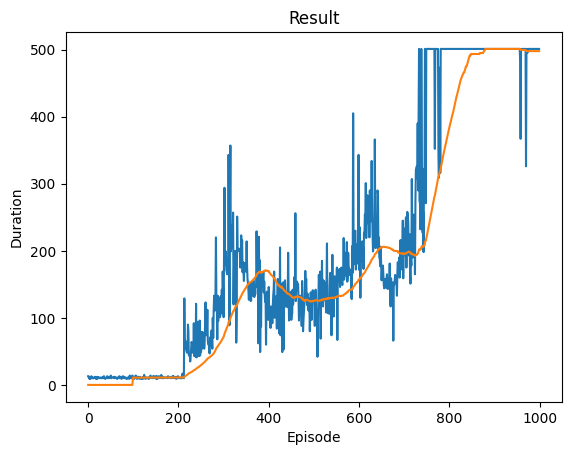

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
import gym
import random
import numpy as np
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

EPISODES = 1000
MEMORY_SIZE = 1000
BATCH_SIZE = 128
GAMMA = 0.95
EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 10
TARGET_UPDATE = 1000
TAU = 0.005
LR = 1e-4

# set up matplotlib
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class DQN(nn.Module):
  def __init__(self, state_size, action_size):
      super(DQN, self).__init__()
      self.fc = nn.Sequential(
          #(in_features, out_features)
          nn.Linear(state_size, 128),
          nn.ReLU(),
          nn.Linear(128, 128),
          nn.ReLU(),
          nn.Linear(128, action_size)
      )

  def forward(self, x):
      return self.fc(x)

class DQNAgent:
  def __init__(self, state_size, action_size):
      self.state_size = state_size
      self.action_size = action_size
      self.memory = deque(maxlen=MEMORY_SIZE)
      self.gamma = GAMMA
      self.eps_start = EPS_START
      self.eps_end = EPS_END
      self.eps_decay = EPS_DECAY
      self.policy_net = DQN(state_size, action_size)
      self.target_net = DQN(state_size, action_size)
      self.target_net.load_state_dict(self.policy_net.state_dict())
      self.target_net.eval()
      self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
      self.steps_done = 0

  def select_action(self, state):
      sample = random.random()
      eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
          np.exp(-1.0 * self.steps_done / self.eps_decay)
      self.steps_done += 1
      if sample > eps_threshold:
          with torch.no_grad():
              return self.policy_net(state).max(1)[1].view(1, 1)
      else:
          return torch.tensor([[random.randrange(self.action_size)]], dtype=torch.long)

  def store_transition(self, state, action, next_state, reward, done):
      self.memory.append((state, action, next_state, reward, done))

  def optimize_model(self):
      if len(self.memory) < BATCH_SIZE:
          return
      transitions = random.sample(self.memory, BATCH_SIZE)
      batch = Transition(*zip(*transitions))

      non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
      non_final_next_states = torch.cat([s for s in batch.next_state
                                                  if s is not None])
      state_batch = torch.cat(batch.state)
      action_batch = torch.cat(batch.action)
      reward_batch = torch.cat(batch.reward)

      state_action_values = self.policy_net(state_batch).gather(1, action_batch)
      next_state_values = torch.zeros(BATCH_SIZE)

      next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
      expected_state_action_values = (next_state_values * self.gamma) + reward_batch

      loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))


      self.optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 5)
      self.optimizer.step()

episode_durations = []

def plot_durations(show_result=False):
  plt.figure(1)
  durations_t = torch.tensor(episode_durations, dtype=torch.float)
  if show_result:
      plt.title('Result')
  else:
      plt.clf()
      plt.title('Training...')
  plt.xlabel('Episode')
  plt.ylabel('Duration')
  plt.plot(durations_t.numpy())
  # Take 100 episode averages and plot them too
  if len(durations_t) >= 100:
      means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
      means = torch.cat((torch.zeros(99), means))
      plt.plot(means.numpy())

  plt.pause(0.001)  # pause a bit so that plots are updated
  if is_ipython:
      if not show_result:
          display.display(plt.gcf())
          display.clear_output(wait=True)
      else:
          display.display(plt.gcf())

if __name__ == "__main__":
  env = gym.make('CartPole-v1')
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n
  agent = DQNAgent(state_size, action_size)

  scores = []
  episodes = []
  counter = 0
  for e in range(EPISODES):

      state = env.reset()
      state = torch.tensor(state, dtype=torch.float32).view(1, -1)
      done = False
      score = 0
      while not done:
        counter+=1
        action = agent.select_action(state)                                     # Select an action using the agent's policy
        next_state, reward, done, _ = env.step(action.item())                   # Take the selected action in the environment and receive the next state, re ward, and done flag
        score += reward                                                         # Accumulate the reward to calculate the episode score
        reward = torch.tensor([reward], dtype=torch.float32)                    # Convert reward to a torch tensor
        next_state = torch.tensor(next_state, dtype=torch.float32).view(1, -1)  # Convert the next state to a torch tensor
        if done:
            next_state = None
        agent.store_transition(state, action, next_state, reward, done)         # Store the transition in the agent's replay memory
        state = next_state                                                      # Update the agent's neural network
        agent.optimize_model()

        # Update the target network using a soft update strategy
        target_net_state_dict = agent.target_net.state_dict()
        policy_net_state_dict = agent.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        agent.target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(counter+1)
            scores.append(score)
            episodes.append(e)
            plot_durations()
      counter = 0

      # Periodically update the target network with the weights of the policy network
      if e % TARGET_UPDATE == 0:
          agent.target_net.load_state_dict(agent.policy_net.state_dict())

  print('Complete')
  plot_durations(show_result=True)
  plt.ioff()
  plt.show()


This cell trains a DQN agent on the CartPole-v1 environment several times in a row.
Each run starts with a fresh agent, goes through a set number of episodes, and records things like average score, runtime, and success rate.

Afterward, it also puts together a few plots — showing how the agent learns over time, how scores are distributed, how exploration vs. exploitation plays out, and how success rates stack up across runs.

In [ ]:
import gym
import random
import numpy as np
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

ITERATIONS = 10 # Number of iterations to run
episode_durations = []

def plot_durations(iteration, show_result=False):
    plt.figure(iteration + 2)  # Use a different figure number for each iteration
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title(f'Iteration {iteration + 1}: Result')
    else:
        plt.clf()
        plt.title(f'Iteration {iteration + 1}: Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

if __name__ == "__main__":
    start_script_time = time.time()
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    success_count = 0
    total_episodes_to_500 = 0

    all_averages = []
    all_runtimes = []
    all_iteration_scores = []
    all_epsilon_values = []
    cumulative_success_rates = []
    instanse_succes_rate = []


    # Fraction points for plotting scores
    fraction_points = [0.25, 0.5, 0.75, 1.0]

    for iteration in range(ITERATIONS):
        start_time = time.time()
        agent = DQNAgent(state_size, action_size)  # Create a new agent for each iteration

        scores = []
        episodes = []
        counter = 0

        iteration_epsilon_values = []

        for e in range(EPISODES):
            state = env.reset()
            state = torch.tensor(state, dtype=torch.float32).view(1, -1)
            done = False
            score = 0

            while not done:
                counter += 1
                action = agent.select_action(state)
                next_state, reward, done, _ = env.step(action.item())
                score += reward
                reward = torch.tensor([reward], dtype=torch.float32)
                next_state = torch.tensor(next_state, dtype=torch.float32).view(1, -1)

                if done:
                    next_state = None

                agent.store_transition(state, action, next_state, reward, done)
                state = next_state
                agent.optimize_model()

                target_net_state_dict = agent.target_net.state_dict()
                policy_net_state_dict = agent.policy_net.state_dict()

                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)

                agent.target_net.load_state_dict(target_net_state_dict)

                if done:
                    episode_durations.append(counter + 1)

                    scores.append(score)
                    episodes.append(e)
                    iteration_epsilon_values.append(agent.eps_end + (agent.eps_start - agent.eps_end) * np.exp(-1.0 * agent.steps_done / agent.eps_decay))
                    # Plot scores at different fraction points


            counter = 0

            if e % TARGET_UPDATE == 0:
                agent.target_net.load_state_dict(agent.policy_net.state_dict())

        iteration_runtime = time.time() - start_time
        all_runtimes.append(iteration_runtime)
        all_iteration_scores.append(scores)

        all_epsilon_values.append(iteration_epsilon_values)

        # Print additional metrics for each iteration
        print(f'\nIteration {iteration + 1}/{ITERATIONS}:')
        print(f'Average Score: {np.mean(scores):.2f}')
        print(f'Standard Deviation of Score: {np.std(scores):.2f}')
        print(f'Maximum Score: {np.max(scores):.2f}')
        print(f'Minimum Score: {np.min(scores):.2f}')
        print(f'Number of Episodes to Reach 500 Steps: {episodes[-1] + 1 if episode_durations[-1] >= 500 else "Not Achieved"}')
        print(f'Iteration Runtime: {iteration_runtime:.2f} seconds')


        # Store the average performance for each run
        all_averages.append(np.mean(scores))


        if episode_durations[-1] >= 500:
            success_count += 1
            total_episodes_to_500 += episodes[-1] + 1
        plot_durations(iteration, show_result=True)

        # Calculate cumulative success rate
        cumulative_success_rate = np.sum(np.array(iteration_scores) >= 500) / len(iteration_scores) * 100
        cumulative_success_rates.append(cumulative_success_rate)

        # Plot success rate compared to runtime for each iteration
        plt.figure(figsize=(10, 6))
        plt.plot(np.cumsum(all_runtimes), cumulative_success_rates, marker='o', linestyle='-', color='purple')
        plt.title(f'Success Rate Compared to Runtime (Iteration {iteration + 1})')
        plt.xlabel('Cumulative Runtime (seconds)')
        plt.ylabel('Cumulative Success Rate (%)')
        plt.grid(True)
        plt.show()


    # Calculate and print the final success rate and average episodes to reach 500
    final_success_rate = success_count / ITERATIONS * 100
    average_episodes_to_500 = total_episodes_to_500 / success_count if success_count > 0 else 0

    print(f'\nFinal Success Rate: {final_success_rate:.2f}%')
    print(f'Average Episodes to Reach 500: {average_episodes_to_500:.2f}')

    total_script_runtime = time.time() - start_script_time
    print(f'\nTotal Runtime of the Script: {total_script_runtime:.2f} seconds')

    print(all_runtimes)



# Plot the learning curve for each iteration
    plt.figure(figsize=(12, 8))
    for i, iteration_scores in enumerate(all_iteration_scores):
        plt.plot(iteration_scores, label=f'Iteration {i + 1}')
    plt.title('Learning Curve for Each Iteration')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the average performance across iterations
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, ITERATIONS + 1), all_averages, marker='o', linestyle='-', color='b')
    plt.title('Average Performance Across Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Average Score')
    plt.grid(True)
    plt.show()

    # Plot the distribution of scores for each iteration
    plt.figure(figsize=(12, 8))
    plt.boxplot(all_iteration_scores, labels=[f'Iteration {i + 1}' for i in range(ITERATIONS)])
    plt.title('Distribution of Scores Across Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

    # Plot the success rate over iterations
    success_rates = [np.sum(np.array(iteration_scores) >= 500) / len(iteration_scores) * 100 for iteration_scores in all_iteration_scores]
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, ITERATIONS + 1), success_rates, marker='o', linestyle='-', color='g')
    plt.title('Success Rate Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Success Rate (%)')
    plt.grid(True)
    plt.show()

    # Plot the exploration-exploitation trade-off
    plt.figure(figsize=(10, 6))
    for i, iteration_epsilon_values in enumerate(all_epsilon_values):
        plt.plot(iteration_epsilon_values, label=f'Iteration {i + 1}')
    plt.title('Exploration-Exploitation Trade-off')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the distribution of rewards
    plt.figure(figsize=(12, 8))
    plt.hist(np.concatenate(all_iteration_scores), bins=20, edgecolor='black')
    plt.title('Distribution of Rewards')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Plot the cumulative success rate over iterations
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, ITERATIONS + 1), cumulative_success_rates, marker='o', linestyle='-', color='r')
    plt.title('Cumulative Success Rate Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Cumulative Success Rate (%)')
    plt.grid(True)
    plt.show()

